HF E_max: 9.871630493000342
HF E_min: 0
011111111111 000000000000
{'111111111110': 1}
{'111111111110': -2.6655419399501667e-09, '111111111011': 0.4293606530310168, '111111101111': 0.018981756064837985, '101111111111': -0.6248226463510367}
{'111111111110': -6.4909654327688995e-09, '111111111011': 0.009343874730604718, '111111101111': -0.07139102456797246, '101111111111': 0.0042520308092570125}
{'111111111110': -2.2980101139029727e-07, '111111111011': -7.348684619157275e-09, '111111101111': -9.66770230710623e-10, '101111111111': -8.345054508529515e-11}
{'111111111110': 0.0004386495846085276, '111111111011': -0.012776558259042444, '111111101111': -0.003136319125242163, '101111111111': -0.04648407096777241}
[13.575416478832102, 10.298581000890804, 9.719666837606406, 9.718184454589803, 9.718184454589803] [13.575416478832102, 13.579201739047438, 13.579448219167265, 13.579448404879459, 13.579448404879459]


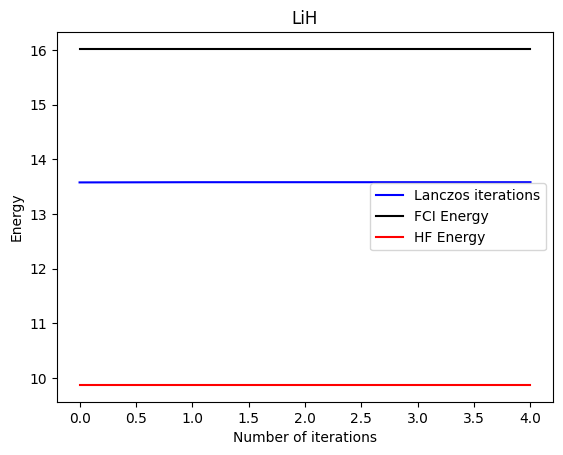

In [1]:
import pickle
import io
import numpy as np
import scipy
from openfermion import FermionOperator
import openfermion as of
from itertools import product
from sdstate import *
import matplotlib.pyplot as plt


def lanczos_step(Hf: FermionOperator, steps, state = None, ne = None):
    """Applies lanczos iteration on the given 2e tensor Htbt, with number of steps given by steps,
    with initial state as input or number of electrons as input ne.
    Returns normalized states in each iteration, and a tridiagonal matrix with main diagonal in A and sub-diagonal in B.
    """
    n_qubits = of.utils.count_qubits(Hf)
    if state == None:
        if ne == None:
            ne = n_qubits // 2
        state = sdstate(int("1"*ne + "0"*(n_qubits - ne), 2))
        state += sdstate(int("0"*(n_qubits - ne) + "1"*ne, 2))
    state.normalize()
    print(state)
    tmp = state @ Hf
    ai = tmp @ state
    tmp -= ai * state
    A = [ai]
    B = []
    states = [state]
    vi = tmp
    E_mins = [state.exp(Hf)]
    E_maxs = [state.exp(Hf)]
    for i in range(1,steps):
        bi = tmp.norm()
        if bi != 0:
            vi = tmp / bi
        tmp = vi @ Hf
        ai = vi @ tmp
        tmp -= ai * vi 
        tmp -= bi * states[i - 1]
        states.append(vi)
        A.append(ai)
        B.append(bi)
        eigs, _ = eigh_tridiagonal(A,B)
        print(tmp)
        E_mins.append(min(eigs))
        E_maxs.append(max(eigs))
    return states, E_mins, E_maxs

def load_hamiltonain(file_name):
    with open("./Hamiltonians/"+file_name, 'rb') as f:
        loaded_Hf = pickle.load(f)
    return loaded_Hf
#     Constants
steps = 5
run_FCI = True

if __name__ == "__main__":

#     "LiH", "H4-line", "H4-rectangle", "H4-square", "H2O"
    for name in ["LiH"]:
#         name = "LiH"
        Hf = load_hamiltonain(name + ".pkl")
        n =  of.count_qubits(Hf)  
        const = Hf.terms[()]

        max_state, min_state, HF_max, HF_min = HF_spectrum_range(Hf, multiprocessing = False)
        print(max_state, min_state)
        x = list(range(steps))
        _, Lanczos_mins, Lanczos_maxes = lanczos_step(Hf, steps, state = sdstate(int(max_state,2), n_qubit = n))
#         print([i + const for i in Lanczos_mins])
#         Running FCI by diagnolizing the Hamiltonian in full Fock Space, takes 
        print( Lanczos_mins, Lanczos_maxes)
        plt.plot(x, Lanczos_maxes, label = "Lanczos iterations", color = "blue")
        if run_FCI:
            eigenvalues = of.linalg.eigenspectrum(Hf, n)
            E_max = max(eigenvalues)
            E_min = min(eigenvalues)
            y_min = [E_max] * (steps)
            plt.plot(x, y_min, label = "FCI Energy", color = "black")
        y_HF = [HF_max] * (steps)
        plt.title(name)
        plt.plot(x, y_HF, label = "HF Energy", color = "red")
        plt.ylabel("Energy")
        plt.xlabel("Number of iterations")
        plt.legend()
        plt.show()

In [ ]:
# _, Lanczos_mins, Lanczos_maxs = lanczos_step(Htbt, steps, state = fstate(min_state))
# print([i + const for i in Lanczos_mins])
# y_min = [E_min] * (steps)
# y_HF = [HF_min] * (steps)
# y_MP2 = [MP2_min] * (steps)
# x = list(range(steps))
# plt.title(name)
# plt.plot(x, Lanczos_mins, label = "Lanczos iterations", color = "blue")
# plt.plot(x, y_HF, label = "HF Energy", color = "red")
# plt.plot(x, y_min, label = "FCI Energy", color = "black")
# plt.plot(x, y_MP2, label = "MP2 Energy", color = "magenta")
# plt.ylabel("Energy")
# plt.xlabel("Number of iterations")
# plt.legend()
# plt.show()

In [ ]:
#         Construct obt and tbt, in Physist notation
#         obt = feru.get_obt(Hf, n = n, spin_orb = True )
#         tbt = feru.get_two_body_tensor(Hf, n = n)
#         obt_eigs, _ = np.linalg.eig(obt)
        # Construct antisymmetric 
#         atbt = np.zeros(tbt.shape)
#         for i,j,k,l in product(range(n), repeat = 4):
#             atbt[i,j,k,l] = tbt[i,j,k,l] - tbt[i,j,l,k]
#         tmp = {}
#         # Construct Chemist notation Htbt
#         Htbt = feru.get_chemist_tbt(Hf, n, spin_orb = True)
#         one_body = varu.get_one_body_correction_from_tbt(Hf, feru.get_chemist_tbt(Hf))
#         onebody_matrix = feru.get_obt(one_body, n = n, spin_orb = True)
#         Htbt += feru.onebody_to_twobody(onebody_matrix)
#         print(MP2_min +const)
#         print(E_min + const)